In [1]:
from functools import partial
from pathlib import Path
from typing import Any

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.continuous import AbstractODE, Lorenz63
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.custom_types import FloatScalar
from dynamics_discovery.data import TimeSeriesDataset
from dynamics_discovery.data.loaders import (
    AbstractBatching,
    FullBatching,
    MiniBatching,
    RandomSampleBatching,
    SegmentLoader,
)
from dynamics_discovery.loss_functions import AbstractDynamicsLoss
from dynamics_discovery.models import ODEModel
from dynamics_discovery.models.abstract import AbstractDynamicsModel
from dynamics_discovery.neighborhood import NeighborhoodSegmentLoader, NormalODE
from jaxtyping import Array, Float, PRNGKeyArray, PyTree
from ott.utils import batched_vmap
from tqdm import tqdm


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

In [2]:
noise = 0.0
downsample = 2
dataset, transform = (
    TimeSeriesDataset.from_hdf5(datadir / "lorenz63_large.hdf5")
    .downsample(downsample)
    .add_noise(noise)
    .standardize()
)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

In [22]:
loader = NeighborhoodSegmentLoader(
    dataset,
    2,
    2,
    FullBatching,
)

In [23]:
loader = NeighborhoodSegmentLoader(
    dataset,
    2,
    30,
    MiniBatching(batch_size=4096, permute_initial=False, drop_last=False),
)

In [4]:
def get_normal_direction(points: Float[Array, "batch dim"]):
    points_centered = points  # - jnp.mean(points, axis=0)
    _, _, Q_T = jnp.linalg.svd(points_centered, full_matrices=False)
    return Q_T[2]


class NormalVectorSegmentLoader(SegmentLoader):
    num_neighbors: int = eqx.field(static=True)
    _normals: np.ndarray

    def __init__(
        self,
        dataset: TimeSeriesDataset,
        segment_length: int,
        num_neighbors: int,
        batch_strategy: AbstractBatching,
        *,
        normal_calculation_chunk_size: int = 4096,
    ):
        super().__init__(dataset, segment_length, batch_strategy)
        self.num_neighbors = num_neighbors
        self._normals = self._calculate_normals(dataset, normal_calculation_chunk_size)

    def _calculate_normals(self, dataset: TimeSeriesDataset, chunk_size):
        neighborhood_loader = NeighborhoodSegmentLoader(
            dataset,
            self.segment_length,
            self.num_neighbors,
            MiniBatching(chunk_size, permute_initial=False, drop_last=False),
        )

        get_normal_direction_batch = jax.vmap(jax.vmap(get_normal_direction))

        # @eqx.filter_jit
        def _step(loader_state):
            batch, loader_state = neighborhood_loader.load_batch(loader_state)
            _, u, u_nn = batch
            du_nn: Float[Array, "batch time neighbors dim"] = u_nn - jnp.expand_dims(
                u, axis=-2
            )
            normals: Float[Array, "batch time dim"] = get_normal_direction_batch(du_nn)
            return normals, loader_state

        normals = []
        loader_state = neighborhood_loader.init()
        for _ in tqdm(range(neighborhood_loader.num_batches)):
            normal, loader_state = _step(loader_state)
            normals.append(np.asarray(normal))
        return np.concatenate(normals, axis=0)

    def load_batch(self, loader_state: PyTree) -> tuple[PyTree[Array], PyTree]:
        (batch_state,) = loader_state
        linear_indices, batch_state_next = self.batch_strategy.generate_batch(
            batch_state
        )
        t_batch, u_batch = self.get_segments(
            *self.linear_to_sample_indices(linear_indices)
        )
        normal_batch = jnp.take(self._normals, linear_indices, axis=0)
        batch = (t_batch, u_batch, normal_batch)
        loader_state_next = (batch_state_next,)
        return batch, loader_state_next

In [5]:
get_normal_direction_batch = jax.vmap(jax.vmap(get_normal_direction))


class NormalVectorSegmentLoader2(NeighborhoodSegmentLoader):
    def __init__(
        self,
        dataset: TimeSeriesDataset,
        segment_length: int,
        num_neighbors: int,
        batch_strategy: AbstractBatching,
    ):
        super().__init__(dataset, segment_length, num_neighbors, batch_strategy)

    def load_batch(
        self, loader_state: PRNGKeyArray
    ) -> tuple[
        Float[Array, "{self.batch_size} {self.segment_length}"],
        Float[Array, "{self.batch_size} {self.segment_length} dim"],
        Float[
            Array, "{self.batch_size} {self.segment_length} {self.num_neighbors} dim"
        ],
    ]:
        (t_batch, u_batch, u_nn_batch), loader_state_next = super().load_batch(
            loader_state
        )
        normal_batch = get_normal_direction_batch(u_nn_batch)
        return (t_batch, u_batch, normal_batch), loader_state_next

In [23]:
loader = NormalVectorSegmentLoader2(dataset, 2, 10, RandomSampleBatching(2048))


In [24]:
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

In [25]:
velocities = eqx.filter_vmap(eqx.filter_vmap(lorenz_scaled.rhs))(batch[0], batch[1])
velocities.shape

(2048, 2, 3)

In [26]:
batch[2].shape

(2048, 2, 3)

In [27]:
angle = jnp.linalg.vecdot(velocities, batch[2]) / (
    jnp.linalg.norm(velocities, axis=-1) * jnp.linalg.norm(batch[2], axis=-1)
)

<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1595357/2302121795.py:4: SyntaxWarning: invalid escape sequence '\h'
  axes[0].set_xlabel("$\hat{n}_{data, i} \cdot f(t_{i}, u_{i})$")
/tmp/ipykernel_1595357/2302121795.py:5: SyntaxWarning: invalid escape sequence '\h'
  axes[1].set_xlabel("$\hat{n}_{data, i+1} \cdot f(t_{i+1}, u_{i+1})$")


Text(0.5, 0, '$\\hat{n}_{data, i+1} \\cdot f(t_{i+1}, u_{i+1})$')

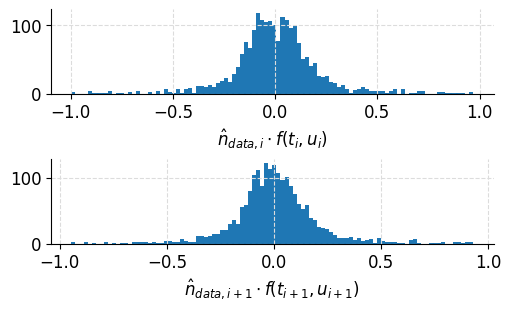

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(5, 3))
for i, ax in enumerate(axes):
    ax.hist(angle[:, i], bins=100)
axes[0].set_xlabel("$\hat{n}_{data, i} \cdot f(t_{i}, u_{i})$")
axes[1].set_xlabel("$\hat{n}_{data, i+1} \cdot f(t_{i+1}, u_{i+1})$")

In [34]:
normal_ode = NormalODE(ODEModel(lorenz_scaled))
u_pred, normal_pred = eqx.filter_vmap(normal_ode.solve)(
    batch[0], (batch[1][:, 0], batch[2][:, 0])
)

In [35]:
normal_pred.shape

(2048, 2, 3)

In [36]:
angle2 = jnp.linalg.vecdot(velocities, normal_pred) / (
    jnp.linalg.norm(velocities, axis=-1) * jnp.linalg.norm(normal_pred, axis=-1)
)
angle2

Array([[ 0.02084032,  0.01916251],
       [-0.08722542, -0.07067472],
       [-0.07534968, -0.04016197],
       ...,
       [ 0.42821321,  0.41391035],
       [ 0.06175338,  0.0592272 ],
       [ 0.14972907,  0.11551715]], dtype=float64)

<>:4: SyntaxWarning: invalid escape sequence '\h'
<>:4: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1595357/3078135380.py:4: SyntaxWarning: invalid escape sequence '\h'
  "$||\hat{n}_{data, i} \cdot f(t_{i}, u_{i})-\hat{n}_{pred, i+1} \cdot f(t_{i+1}, u_{i+1})||_2^2$"


Text(0.5, 0, '$||\\hat{n}_{data, i} \\cdot f(t_{i}, u_{i})-\\hat{n}_{pred, i+1} \\cdot f(t_{i+1}, u_{i+1})||_2^2$')

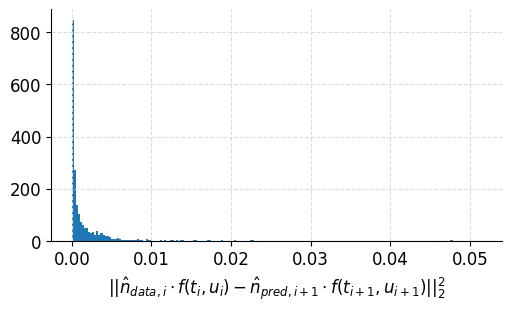

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist((angle2[:, 0] - angle2[:, 1]) ** 2, bins=200)
ax.set_xlabel(
    "$||\hat{n}_{data, i} \cdot f(t_{i}, u_{i})-\hat{n}_{pred, i+1} \cdot f(t_{i+1}, u_{i+1})||_2^2$"
)

In [140]:
normals = []
loader_state = loader.init()
for _ in tqdm(range(loader.num_batches)):
    batch, loader_state = loader.load_batch(loader_state)
    normals.append(np.asarray(get_normal_direction(batch[2])))
normals = np.concatenate(normals, axis=0)

100%|██████████| 304/304 [00:53<00:00,  5.67it/s]


In [141]:
out = get_normal_direction(batch[2])
out.shape

(3912, 2, 3)

In [142]:
batch[2].shape

(3912, 2, 30, 3)

In [143]:
batch[1].shape

(3912, 2, 3)

In [31]:
batch[1][t_ind][0].shape

(3,)

In [115]:
normals_batch.shape

(2, 3)

In [6]:
loader = NeighborhoodSegmentLoader(
    dataset,
    2,
    10,
    RandomSampleBatching(batch_size=2048),
)
loader_state = loader.init()
batch, loader_state = loader.load_batch(loader_state)

In [8]:
batch[2].shape

(2048, 2, 10, 3)

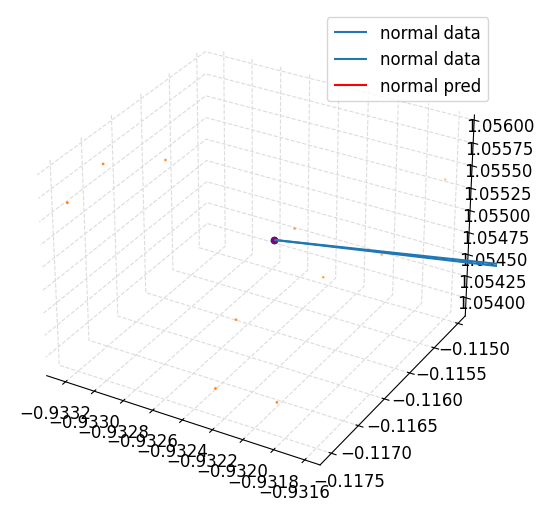

In [7]:
normal_ode = NormalODE(ODEModel(lorenz_scaled))
t_ind = 50

u_center = batch[1][t_ind]
u_neigh = batch[2][t_ind]
fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
# ax.scatter(*u_center[0])
# ax.scatter(*u_neigh[0].T)

normals_batch = jax.vmap(get_normal_direction)(u_neigh - jnp.expand_dims(u_center, -2))
ax.quiver(*u_center[1], *normals_batch[0], length=0.01, label="normal data")
# ax.scatter(*u_center[0])
# ax.scatter(*u_neigh[0].T, s=1)

# ax.quiver(*u_center[0], *normals_batch[0], length=0.005)
ax.quiver(*u_center[1], *normals_batch[1], length=0.01, label="normal data")
ax.scatter(*u_center[1])
ax.scatter(*u_neigh[1].T, s=1)

u_pred, normal_pred = normal_ode.solve(
    batch[0][t_ind], (batch[1][t_ind][0], normals_batch[0])
)
u_pred2 = normal_ode.ode.solve(batch[0][t_ind], batch[1][t_ind][0])
# ax.scatter(*u_pred[1], "o", color="red")
ax.quiver(*u_pred[1], *normal_pred[1], length=0.00001, color="red", label="normal pred")
ax.scatter(*u_pred2[1], "o", color="purple")
ax.legend()

In [ ]:
u_pred2[1]

Array([ 0.47260172,  0.65103892, -0.23504934], dtype=float64)

In [121]:
(jnp.sum(normal_pred[1] ** 2) - jnp.dot(normal_pred[1], normals_batch[1]))

Array(34.07579655, dtype=float64)

In [122]:
normals_batch[0]

Array([ 0.76821127, -0.35094296,  0.53543486], dtype=float64)

In [123]:
normal_pred[1]

Array([ 4.31445183, -4.64389576,  0.50425741], dtype=float64)

In [124]:
directional_cosine_squared(normal_pred[1], normals_batch[1])

Array(0.99997661, dtype=float64)

In [126]:
u_samples = jnp.concatenate((jnp.expand_dims(u_center, axis=-2), u_neigh), axis=-2)
u_samples.shape

(2, 31, 3)

In [127]:
normals = jax.vmap(get_normal_direction)(u_samples)
normals.shape

IndexError: tuple index out of range

In [128]:
t_ind = 50

u_center = u[t_ind]
u_neigh = jnp.expand_dims(u_center, axis=-2) + du[t_ind]
fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
ax.scatter(*u_center[0])
ax.scatter(*u_neigh[0].T)

ax.scatter(*u_center[1])
ax.scatter(*u_neigh[1].T)

NameError: name 'u' is not defined

In [41]:
u_neigh = jnp.expand_dims(u, axis=-2) + du
u_samples_batch = jnp.concatenate((jnp.expand_dims(u, axis=-2), u_neigh), axis=-2)
u_samples_batch.shape

(9991, 10, 31, 3)

In [42]:
normals_batch = jax.vmap(jax.vmap(get_normal_direction))(u_samples_batch)

In [43]:
u.shape

(9991, 10, 3)

In [44]:
normals_batch.shape

(9991, 10, 3)

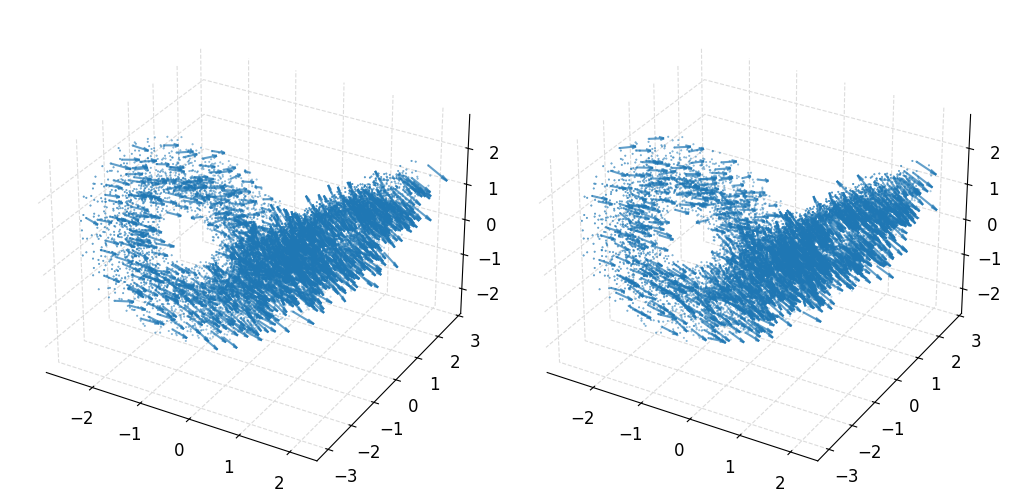

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={"projection": "3d"})
for i, ax in enumerate(axes):
    ax.scatter(*u[:, i].T, s=0.2)
    ax.quiver(*u[::10, i].T, *normals_batch[::10, i].T, length=0.5, alpha=0.7)

In [7]:
class NormalODE(AbstractODE):
    ode: AbstractODE

    @property
    def dim(self) -> int:
        return self.ode.dim * (self.ode.dim + 1)

    @property
    def solver(self) -> dfx.AbstractSolver:
        return self.ode.solver

    @property
    def dt0(self) -> float | None:
        return self.ode.dt0

    @property
    def stepsize_controller(self) -> dfx.AbstractStepSizeController:
        return self.ode.stepsize_controller

    def rhs(self, t, u: tuple[Float[Array, " dim"], Float[Array, " dim"]], args):
        x, Nx = u

        def rhs_ode(x_):
            return self.ode.rhs(t, x_, args)

        dx, vjp_fun = jax.vjp(rhs_ode, x)
        dNx = -vjp_fun(Nx)[0]

        return dx, dNx

    def solve(
        self,
        ts: Float[Array, " time"],
        u0: tuple[Float[Array, " dim"], Float[Array, "dim"]],
        args=None,
        **kwargs,
    ) -> tuple[Float[Array, " time dim"], Float[Array, " time dim"]]:
        sol = dfx.diffeqsolve(
            dfx.ODETerm(self.rhs),
            self.solver,
            ts[0],
            ts[-1],
            self.dt0,
            u0,
            args,
            saveat=dfx.SaveAt(ts=ts),
            stepsize_controller=self.stepsize_controller,
            **kwargs,
        )
        return sol.ys


normal_ode = NormalODE(ODEModel(lorenz_scaled, rtol=1e-6, atol=1e-8))

In [8]:
def directional_cosine_squared(x1, x2):
    denom = jnp.sum(x1 * x1) * jnp.sum(x2 * x2)
    return jnp.dot(x1, x2) ** 2 / denom


def directional_sine_squared(x1, x2):
    return jnp.sum(x2 * x2) - jnp.dot(x1, x2) ** 2 / jnp.sum(x1 * x1)

In [9]:
class NormalLoss(AbstractDynamicsLoss):
    batch_size: int | None = None

    def __call__(
        self,
        model: AbstractDynamicsModel,
        batch: PyTree[Float[Array, "batch ..."]],
        args: Any = None,
        **kwargs: Any,
    ) -> FloatScalar:
        t_data, u_data, Nu_data = batch
        batch_size = u_data.shape[0] if self.batch_size is None else self.batch_size

        @partial(batched_vmap, in_axes=(0, 0, 0), batch_size=batch_size)
        def _loss(t_data_: Float[Array, " time"], u_data_, Nu_data_):
            u_pred, Nu_pred = model.solve(
                t_data_, (u_data_[0], Nu_data_[0]), args, **kwargs
            )
            mse_u = jnp.mean((u_pred - u_data_) ** 2)
            sin_sqr = 1 - jax.vmap(directional_cosine_squared)(Nu_data_, Nu_pred)
            ortho = jax.vmap(directional_cosine_squared)(
                jax.vmap(lambda t_, u_: model.ode.rhs(t_, u_, None))(t_data_, u_data_),
                Nu_data_,
            )
            return mse_u, jnp.mean(sin_sqr), jnp.mean(ortho)

        mse_, sin_sqr_, ortho_ = _loss(t_data, u_data, Nu_data)
        mse_total = jnp.mean(mse_)
        sin_sqr_total = jnp.mean(sin_sqr_)
        return mse_total + sin_sqr_total, {
            "mse": mse_total,
            "normal_loss": sin_sqr_total,
            "ortho_loss": jnp.mean(ortho_),
        }

In [20]:
num_neighbors = 30
loader = NormalVectorSegmentLoader2(
    dataset, 2, num_neighbors, RandomSampleBatching(2048)
)
loader_state = loader.init()
batch, _ = loader.load_batch(loader_state)
batch[3].shape

IndexError: tuple index out of range

In [23]:
batch[2].shape

(2048, 2, 3)

In [16]:
from ott.utils import batched_vmap


loss_fn = NormalLoss()

loader_state = loader.init()
batch, _ = loader.load_batch(loader_state)


@jax.jit
@partial(batched_vmap, batch_size=20, in_axes=(None, 0, 0))
@partial(jax.vmap, in_axes=(None, 0, 0))
def loss_from_params(sigma, beta, rho):
    ode = Lorenz63(sigma, beta, rho)
    model = NormalODE(ODEModel(TransformedODE(ode, transform)))
    return loss_fn(model, batch, None)[1]


beta_grid, rho_grid = jnp.meshgrid(
    jnp.linspace(0, 5.0, 100), jnp.linspace(0.0, 60.0, 100)
)
loss_array = loss_from_params(10.0, beta_grid, rho_grid)

In [17]:
loss_array

{'mse': Array([[ 0.84522411,  0.83040283,  0.81733783, ...,  1.44663732,
          1.45203646,  1.4573363 ],
        [ 0.84492278,  0.83002603,  0.81689279, ...,  1.4471705 ,
          1.4525493 ,  1.45782819],
        [ 0.84467235,  0.82969889,  0.81649646, ...,  1.44733812,
          1.45268939,  1.4579402 ],
        ...,
        [10.59715725, 10.32161188, 10.05593879, ...,  3.99348247,
          3.96697291,  3.94018702],
        [10.92919782, 10.6442989 , 10.36957434, ...,  4.23095045,
          4.20480303,  4.17821137],
        [11.26672376, 10.97228352, 10.68831518, ...,  4.48458465,
          4.45962299,  4.43404968]], dtype=float64),
 'normal_loss': Array([[0.28709685, 0.28798373, 0.28847776, ..., 0.27279058, 0.26924897,
         0.26580142],
        [0.28896731, 0.28926604, 0.28916802, ..., 0.24196818, 0.23872624,
         0.23567109],
        [0.28999869, 0.28969223, 0.2889773 , ..., 0.21866201, 0.21667763,
         0.21485745],
        ...,
        [0.32061131, 0.32051803, 0.

Text(0.5, 0.98, 'Downsample = 40, Noise = 0.0, # neighbors = 30')

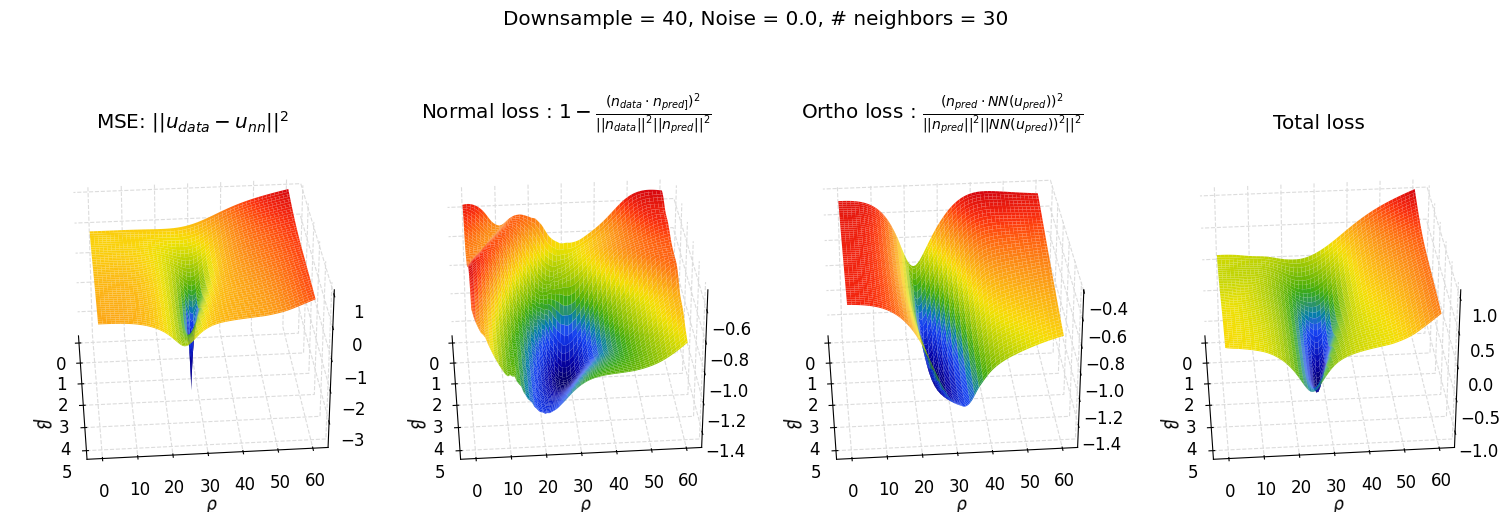

In [18]:
import colorcet as cc
import numpy as np


fig, axes = plt.subplots(
    1, 4, figsize=(15, 6), sharex=True, subplot_kw={"projection": "3d"}
)
values = [
    np.log10(loss_array["mse"]),
    np.log10(loss_array["normal_loss"]),
    np.log10(loss_array["ortho_loss"]),
    np.log10(loss_array["mse"] + loss_array["normal_loss"] + loss_array["ortho_loss"]),
]

for ax, v in zip(axes, values):
    plot = ax.plot_surface(
        beta_grid,
        rho_grid,
        v,
        cmap=cc.cm.rainbow4,
    )
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
    # fig.colorbar(plot, cax=cax, orientation="vertical", shrink=0.3)

    ax.view_init(azim=-5)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\rho$")
axes[0].set_title(r"MSE: $||u_{data}-u_{nn}||^2$")
axes[1].set_title(
    r"Normal loss : $1-\frac{(n_{data}\cdot n_{pred]})^2}{||n_{data}||^2||n_{pred}||^2}$"
)
axes[2].set_title(
    r"Ortho loss : $\frac{(n_{pred}\cdot NN(u_{pred}))^2}{||n_{pred}||^2||NN(u_{pred}))^2||^2}$"
)
axes[-1].set_title(r"Total loss")

fig.suptitle(
    f"Downsample = {downsample}, Noise = {noise}, # neighbors = {num_neighbors}",
    fontsize="large",
)